In [27]:
from collections import namedtuple
from datetime import datetime
import json

from gym.wrappers import RescaleAction, TimeLimit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from stable_baselines3 import TD3
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from tqdm import tqdm

from environments import machine

from environments import ARESEASequential

In [12]:
def load_sequential(model_name, max_episode_steps=50, measure_beam="us"):

    ModelSetup = namedtuple("ModelSetup", ["name","env","model","max_episode_steps","measure_beam"])

    log_dir = f"models/{model_name}"

    def make_env():
        env = ARESEASequential(
            backend="machine",
            backendargs={"measure_beam": measure_beam}
        )
        env = TimeLimit(env, max_episode_steps=max_episode_steps)
        env = RescaleAction(env, -1, 1)
        return env

    env = DummyVecEnv([make_env])
    env = VecNormalize.load(f"{log_dir}/vec_normalize.pkl", env)
    env.training = False
    env.norm_reward = False

    model = TD3.load(f"{log_dir}/model")

    return ModelSetup(model_name, env, model, max_episode_steps, measure_beam)

In [32]:
def beam_meas(info_str=''):
    ea_us = machine.ExperimentalArea(measure_beam="us")
    mu_x, mu_y, sigma_x, sigma_y = ea_us.compute_beam_parameters()
    print(f'Beam size measurement')
    print(info_str)
    print(f"Beam Position: x={mu_x*1e3:.5f} mm / y={mu_y*1e3:.5f} mm")
    print(f"Beam Size: x={sigma_x*1e3:.5f} mm / y={sigma_y*1e3:.5f} mm")
    print('')
    

Beam size measurement
Initial settings
Beam Position: x=-0.03320 mm / y=-0.00489 mm
Beam Size: x=0.05075 mm / y=0.02078 mm


In [13]:
def pack_dataframe(fn):
    def wrapper(setup, desired):
        observations, rewards, beam_images = fn(setup, desired)
        observations = np.array(observations)

        df = pd.DataFrame(np.arange(len(observations)), columns=["step"])
        df["q1"] = observations[:,0]
        df["q2"] = observations[:,1]
        df["cv"] = observations[:,2]
        df["q3"] = observations[:,3]
        df["ch"] = observations[:,4]
        df["mup_x"] = observations[:,5]
        df["mup_y"] = observations[:,6]
        df["sigmap_x"] = observations[:,7]
        df["sigmap_y"] = observations[:,8]
        df["mu_x"] = observations[:,9]
        df["mu_y"] = observations[:,10]
        df["sigma_x"] = observations[:,11]
        df["sigma_y"] = observations[:,12]
        df["reward"] = [np.nan] + rewards
        df["beam_image"] = beam_images

        df["model_name"] = setup.name
        df["max_episode_steps"] = setup.max_episode_steps
        df["measure_beam"] = setup.measure_beam

        return df
    
    return wrapper

In [33]:
@pack_dataframe
def run(setup, problem):
    env, model = setup.env, setup.model

    if problem is not None:
        if "initial" in problem:
            env.unwrapped.next_initial = problem["initial"]
        if "desired" in problem:
            env.unwrapped.next_desired = problem["desired"]

    observations = []
    rewards = []
    beam_images = []

    observation = env.reset()
    observations.append(env.unnormalize_obs(observation).squeeze())
    beam_images.append(env.get_attr("backend")[0].last_beam_image)
    
    env.get_attr("unwrapped")[0].next_initial = "stay"
    
    beam_meas('Initial settings')

    with tqdm(total=setup.max_episode_steps) as pbar:
        done = False
        while not done:
            action, _ = model.predict(observation, deterministic=True)
            observation, reward, done, info = env.step(action)

            observations.append(env.unnormalize_obs(observation).squeeze())
            rewards.append(reward.squeeze())
            beam_images.append(env.get_attr("backend")[0].last_beam_image)

            pbar.update(1)

    observations[-1] = env.unnormalize_obs(info[0]["terminal_observation"].squeeze())
    
    beam_meas('Final settings')

    return observations, rewards, beam_images

In [59]:
model_name = "fearless-wildflower-989"
setup = load_sequential(model_name)

In [ ]:
with open("problems_3.json", "r") as f:
    problems = json.load(f)

In [ ]:
maxfev = 20
run_name = "shenaninganz_initsimplex"
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")

df = run(setup, problems[0], maxfev=maxfev)

df.to_pickle(f"machine_studies/agent_{timestamp}_{run_name}_{maxfev}.pkl")

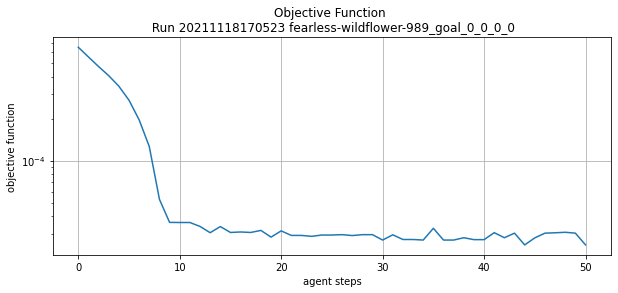

In [61]:
# Compute MAE
df["delta_mu_x"] = np.abs(df["mup_x"] - df["mu_x"])
df["delta_mu_y"] = np.abs(df["mup_y"] - df["mu_y"])
df["delta_sigma_x"] = np.abs(df["sigmap_x"] - df["sigma_x"])
df["delta_sigma_y"] = np.abs(df["sigmap_y"] - df["sigma_y"])
df["mae"] = (df["delta_mu_x"] + df["delta_mu_y"] + df["delta_sigma_x"] + df["delta_sigma_y"]) / 4

plt.figure(figsize=(10,4))
plt.plot(df["mae"])
plt.title(f"Objective Function \n Run {timestamp} {run_name}")
plt.xlabel("agent steps")
plt.ylabel("objective function")
plt.grid(True)

plt.savefig(f"machine_studies/plots/{timestamp}_{run_name}_objective_plot.pdf", bbox_inches="tight")
plt.savefig(f"machine_studies/plots/{timestamp}_{run_name}_objective_plot.png", bbox_inches="tight")

plt.yscale("log")

plt.savefig(f"machine_studies/plots/{timestamp}_{run_name}_objective_plot_ylog.pdf", bbox_inches="tight")
plt.savefig(f"machine_studies/plots/{timestamp}_{run_name}_objective_plot_ylog.png", bbox_inches="tight")

plt.show()

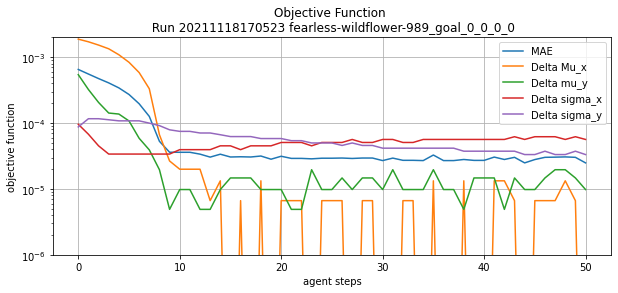

In [62]:
# Compute MAE
df["delta_mu_x"] = np.abs(df["mup_x"] - df["mu_x"])
df["delta_mu_y"] = np.abs(df["mup_y"] - df["mu_y"])
df["delta_sigma_x"] = np.abs(df["sigmap_x"] - df["sigma_x"])
df["delta_sigma_y"] = np.abs(df["sigmap_y"] - df["sigma_y"])
df["mae"] = (df["delta_mu_x"] + df["delta_mu_y"] + df["delta_sigma_x"] + df["delta_sigma_y"]) / 4

plt.figure(figsize=(10,4))
plt.plot(df["mae"], label="MAE")
plt.plot(df["delta_mu_x"], label="Delta Mu_x")
plt.plot(df["delta_mu_y"], label="Delta mu_y")
plt.plot(df["delta_sigma_x"], label="Delta sigma_x")
plt.plot(df["delta_sigma_y"], label="Delta sigma_y")
plt.title(f"Objective Function \n Run {timestamp} {run_name}")
plt.xlabel("agent steps")
plt.ylabel("objective function")
plt.grid(True)
plt.legend()
plt.yscale("log")
plt.ylim(1e-6, 2e-3)
plt.savefig(f"machine_studies/plots/{timestamp}_{run_name}_objective_plot_all.pdf", bbox_inches="tight")
plt.savefig(f"machine_studies/plots/{timestamp}_{run_name}_objective_plot_all.png", bbox_inches="tight")
plt.show()